# ETHtractor

Description

# Table of Contents
- [Import Library](#import-library)
- [Functions](#functions)
    - [Load and Prepare Crypto Data Function](#load-and-prepare-crypto-data-function)
    - [Visualize Time Series Data Function](#visualize-time-series-data-function)
    - [Extract Sequence and Label Data Function](#extract-sequence-and-label-data-function)
    - [Assess and Compare Forecast Model Function](#assess-and-compare-forest-model-function)
- [Read In CSV](#read-in-csv)
- [EDA & Feature Engineering](#eda-&-feature-engineering)
    - [Adfuller](#adfuller)
- [Save CSV](#save-csv)

# Import Library

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use("seaborn-v0_8")

# Functions

## Load and Prepare Crypto Data Function

Load and prepare crypto trading data from a CSV file. The function reads the CSV file, preprocesses the data, cleans irrelevant columns, renaming the remaining ones, and reformatting the trading point column as YYYY-MM-DD format. Returns the processed DataFrame. Useful for loading historical crypto trading data.

In [146]:
def load_and_prepare_crypto_data(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path, header=1)

    # Rename columns
    df.rename(columns={'date': 'trading_point', 'Volume USD': 'volume'}, inplace=True)

    # Convert 'trading_point' to datetime and remove timestamp
    df['trading_point'] = pd.to_datetime(df['trading_point']).dt.strftime('%Y-%m-%d')

    # Sort the DataFrame by 'trading_point'
    df.sort_values(by='trading_point', inplace=True)

    # Drop unnecessary columns
    df.drop(columns=['unix', 'symbol', 'Volume ETH'], inplace=True)

    return df

## Visualize Time Series Data Function

Visualize multiple time-series data in a single plot. The function accepts a DataFrame, optionally takes columns, applies customizable formatting to the chart, and displays it with specified tick sizes. Ideal for investigating trends and correlation within multiple time-series data. Returns no value, as it focuses solely on rendering the plot.

In [147]:
def visualize_time_series_data(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    plt.figure(figsize=(18,9))
    
    for col in cols:
        plt.plot(df[col])
        
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);

## Visualize ARIMA Function

Displays a plot comparing the original ETH prices, training and testing data, and ARIMA model predictions for both training and testing sets.

In [184]:
def visualize_arima(train, test, train_preds, test_preds, suptitle=None, truncate=False):
    plt.figure(figsize=(12,4))

    plt.plot(train, label='training data')
    plt.plot(test, label='testing data')
    
    if truncate:
        plt.plot(train_preds.iloc[truncate:], linestyle='--', label='training preds')
    else:
        plt.plot(train_preds, linestyle='--', label='training preds')
    plt.plot(test_preds, linestyle='--', label='testing preds')

    plt.title('ETH Prices')
    if suptitle:
        plt.suptitle(suptitle)
    plt.legend();

## Extract Sequence and Label Data Function

Extract sequence and label data from a given DataFrame. The function generates pairs of input-output tuples used for building recurrent neural networks, mainly for time series forecasting purposes. Optionally accept the number of previous observations to consider as input and the feature index. Suitable for preparing data to feed into an LSTM-based model. Returns extracted input (X) and output (y) arrays.

In [149]:
def extract_sequence_and_label_data(df, n, feature=-1):
    X = []
    y = []

    for i in range(n, df.shape[0]):
        X.append(df[i - n:i, feature])
        y.append(df[i, feature])

    X = np.expand_dims(np.array(X), -1)
    y = np.expand_dims(np.array(y), -1)

    return X, y

## Assess and Compare Forecast Model Function

Evaluate and visualize the performance of a model compared to the actual test data. The function computes R² Score and Mean Absolute Error metrics, prints the calculated values, and renders a plot contrasting the true and predicted values. Optionally accepts the model, model name, test data, and target data as arguments. Intended for examining time series forecasting models, providing quantitative and qualitative performance insights. Returns R² Score and Mean Absolute Error.

In [150]:
def assess_and_compare_forecast_model(model, model_name='Model', test_data=None, target_data=None):
    y_pred_test = model.predict(test_data)

    try:
        y_pred_test = y_pred_test.yhat
    except:
        pass

    test_rs = r2_score(target_data, y_pred_test)
    print(f"R Squared: {round(test_rs, 3)}")

    test_MAE = mean_absolute_error(target_data, y_pred_test)
    print(f"Mean Absolute Error: {round(test_MAE, 3)}")

    plt.figure(figsize=(12,6))
    plt.plot(y_pred_test, marker='o', linestyle='dashed', label='Predicted Price')
    plt.plot(target_data, label='Actual Price')
    plt.title(f"Comparison of Actual and Predicted ETH-USD Price For {model_name}")
    plt.xlabel('Day')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

    return test_rs, test_MAE

# Read In CSV

In [151]:
eth = load_and_process_data('./data/Bitstamp_ETHUSD_1h.csv')
wiki = pd.read_csv('./data/ethereum_wikipedia.csv', index_col=0, parse_dates=True)

# EDA & Feature Engineering

In [152]:
eth.set_index('trading_point', inplace=True)

In [153]:
eth.index = pd.to_datetime(eth.index)

In [154]:
# Merging based on date
eth = eth.merge(wiki, left_index=True, right_index=True)

In [155]:
eth['close_log'] = np.log1p(eth.close)

In [156]:
eth.describe()

,open,high,low,close,volume,edit_count,sentiment,negative_sentiment,close_log
count,49603.000000,49603.000000,49603.000000,49603.000000,4.960300e+04,49603.000000,49603.000000,49603.000000,49603.000000
mean,1289.892353,1297.194326,1281.990952,1289.892221,1.276547e+06,0.713740,-0.090033,0.180275,6.607265
std,1152.484809,1159.203303,1145.147990,1152.451914,3.488205e+06,0.658491,0.082506,0.107164,1.166073
min,81.270000,82.050000,80.900000,81.270000,0.000000e+00,0.033333,-0.407533,0.000000,4.410007
25%,221.330000,222.770000,219.935000,221.340000,1.379485e+03,0.266667,-0.139572,0.100000,5.404208
50%,1218.500000,1223.930000,1213.550000,1218.400000,1.534269e+05,0.500000,-0.083483,0.166667,7.106114
75%,1901.955000,1908.900000,1894.000000,1901.950000,1.078049e+06,0.933333,-0.033324,0.237302,7.551161
max,4850.000000,4868.790000,4835.420000,4849.060000,1.197434e+08,3.066667,0.103277,0.537381,8.486746


In [157]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49603 entries, 2018-05-15 to 2024-01-11
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open                49603 non-null  float64
 1   high                49603 non-null  float64
 2   low                 49603 non-null  float64
 3   close               49603 non-null  float64
 4   volume              49603 non-null  float64
 5   edit_count          49603 non-null  float64
 6   sentiment           49603 non-null  float64
 7   negative_sentiment  49603 non-null  float64
 8   close_log           49603 non-null  float64
dtypes: float64(9)
memory usage: 3.8 MB


## Adfuller

The Augmented Dickey-Fuller (ADF) test determines whether a time series is stationary or nonstationary. Stationarity implies that the statistical properties of the series remain constant over time, whereas nonstationarity refers to varying characteristics.

In [179]:
dickey_close = adfuller(eth.resample('W').mean().close)

print(f'ADF Statistic: {dickey_close[0]: .2f}')
print(f'p-value: {dickey_close[1]: .2f}')
print('Critical Values:')
for key, value in dickey_close[4].items():
    print(f'\t {key}: {value:.3f}')

ADF Statistic: -1.50
p-value:  0.53
Critical Values:
	 1%: -3.454
	 5%: -2.872
	 10%: -2.572


> The ADF statistic (-1.50) and p-value (0.53) indicate weak evidence against the null hypothesis, suggesting the presence of a unit root, hence, nonstationarity. The p-value exceeds traditional significance levels (e.g., 0.05, 0.10), failing to reject the null hypothesis. Thus, the series is likely nonstationary.

In [180]:
dickey_log = adfuller(eth.resample('W').mean().close_log)

print(f'ADF Statistic: {dickey_log[0]: .2f}')
print(f'p-value: {dickey_log[1]: .2f}')
print('Critical Values:')
for key, value in dickey_log[4].items():
    print(f'\t {key}: {value:.3f}')

ADF Statistic: -0.79
p-value:  0.82
Critical Values:
	 1%: -3.453
	 5%: -2.871
	 10%: -2.572


> Again, the ADF statistic (-0.79) and p-value (0.82) imply insufficient evidence to reject the null hypothesis, concluding that the close_log series is probably nonstationary as well.

In [158]:
eth_month = eth.resample('M').median()
eth_week = eth.resample('W').median()
eth_daily = eth.resample('D').median()

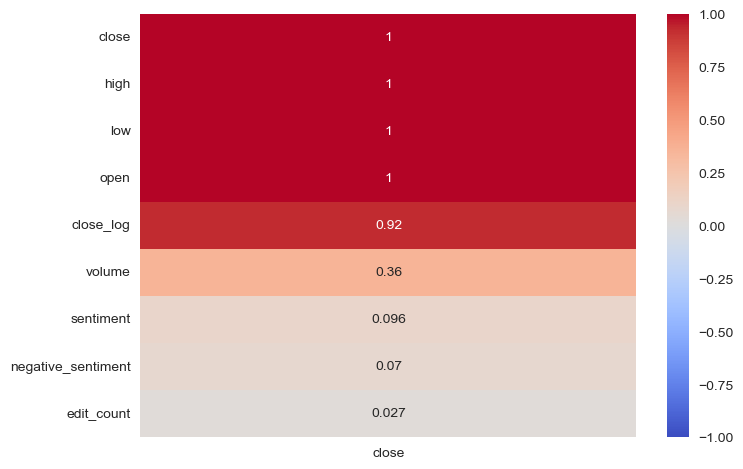

In [159]:
sns.heatmap(eth.corr()[['close']].sort_values(by='close', ascending=False), 
            annot = True, 
            cmap = 'coolwarm',
            vmin = -1,
            vmax = 1);

> high, low, and open are highly correlated to close but sentiment analysis is not.

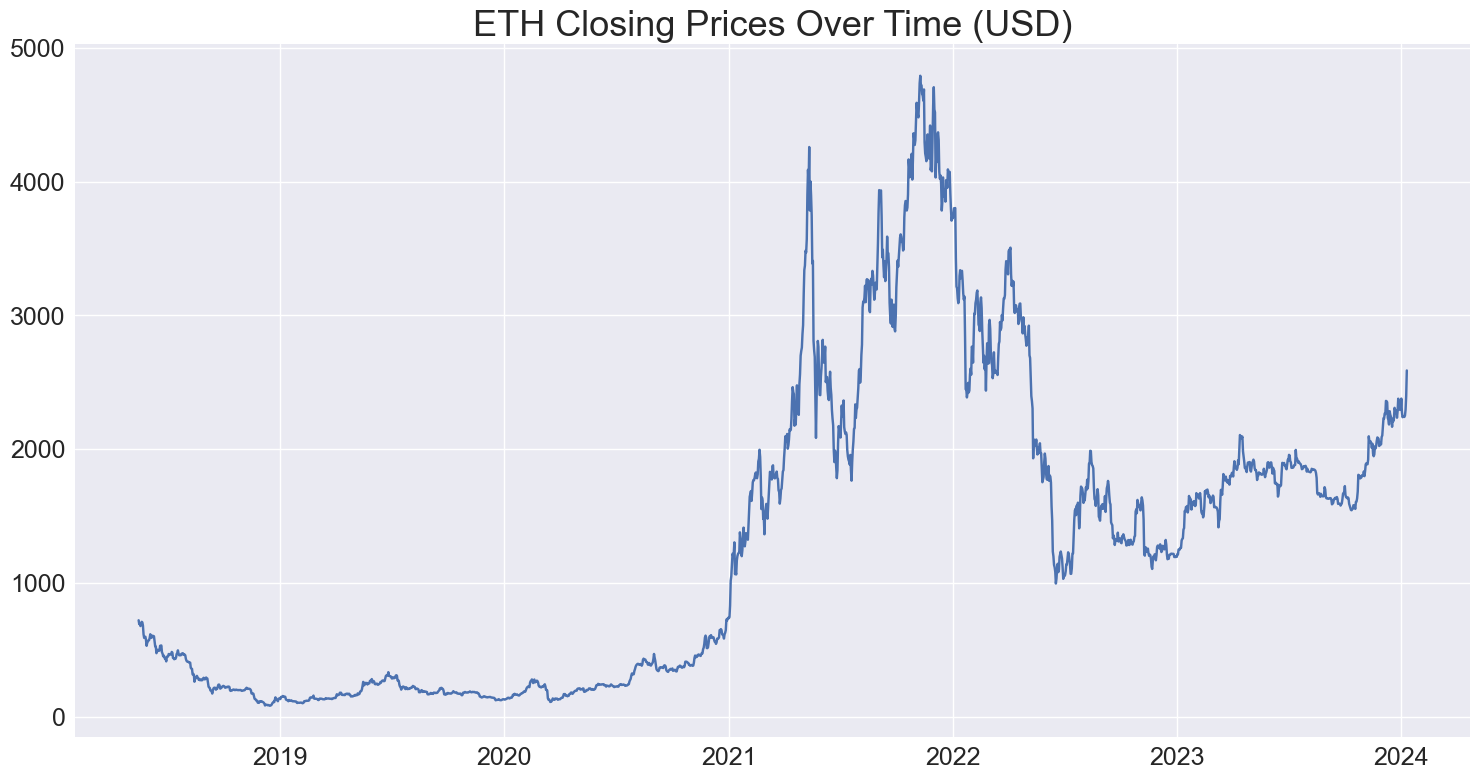

In [168]:
plot_series(eth_daily,
            cols=['close'], title='ETH Closing Prices Over Time (USD)', steps=50)

folder_path = '../ETHtractor/visualizations/'
filename = 'ethereum_closing_prices_over_time.png'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(os.path.join(folder_path, filename));

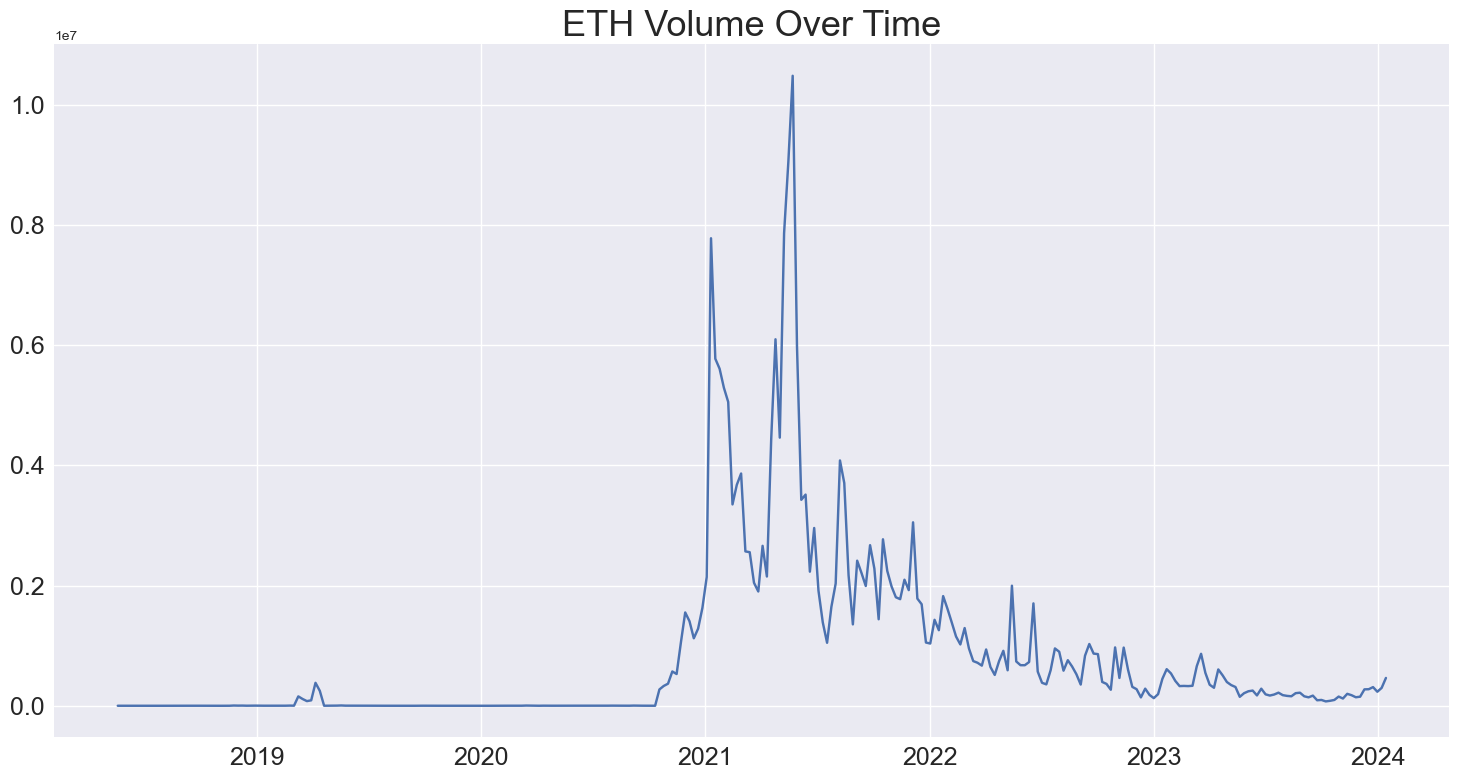

In [167]:
plot_series(eth_week,
            cols=['volume'], title='ETH Volume Over Time')

folder_path = '../ETHtractor/visualizations/'
filename = 'ethereum_vol_over_time.png'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(os.path.join(folder_path, filename));

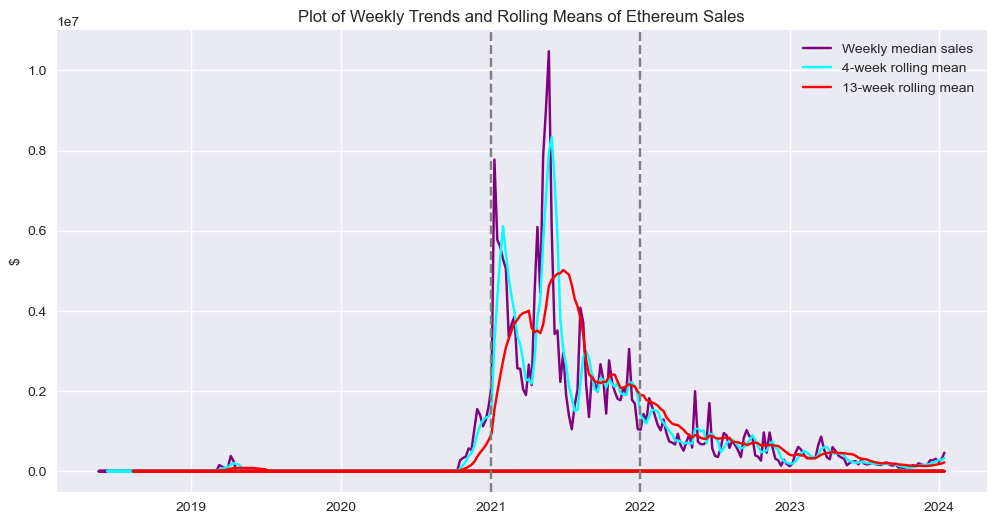

In [171]:
plt.figure(figsize=(12,6))
plt.title('Plot of Weekly Trends and Rolling Means of Ethereum Sales')
plt.ylabel('$')

artists = []
artists.append(plt.plot(eth_week, color='purple', label='Weekly median sales')[0])
artists.append(plt.plot(eth_week.rolling(4).mean(), color='cyan', label='4-week rolling mean')[0])
artists.append(plt.plot(eth_week.rolling(13).mean(), color='red', label='13-week rolling mean')[0])

plt.axvline(pd.to_datetime('2021-01-01'), linestyle='--', c='gray')
plt.axvline(pd.to_datetime('2022-01-01'), linestyle='--', c='gray')

plt.legend(handles=artists)

folder_path = '../ETHtractor/visualizations/'
filename = 'weekly_trends_and_rollings_means_ethereum_sales.png'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(os.path.join(folder_path, filename));

> Due to Ethereum's active 2021, we will analyze the 2021 data.

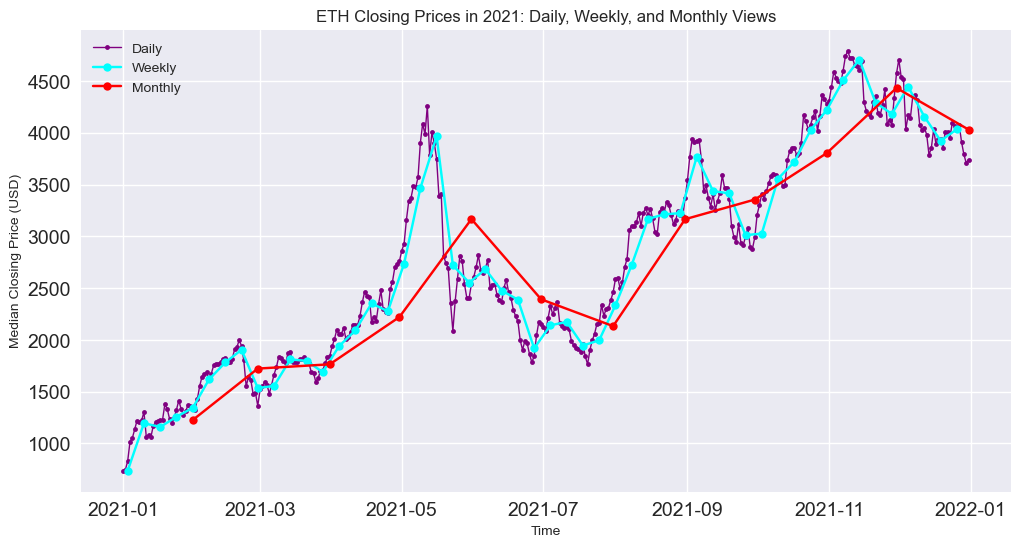

In [169]:
start, end = '2021-01', '2021-12'

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(eth_daily.loc[start:end, 'close'], marker='.', linewidth=1, label='Daily', color='purple')
ax.plot(eth_week.loc[start:end, 'close'], marker='o', markersize=6, linestyle='-', label='Weekly', color='cyan')
ax.plot(eth_month.loc[start:end, 'close'], marker='o', markersize=6, linestyle='-', label='Monthly', color='red')
ax.set_title('ETH Closing Prices in 2021: Daily, Weekly, and Monthly Views')
ax.set_xlabel('Time')
ax.set_ylabel('Median Closing Price (USD)')
ax.tick_params(axis='both', labelsize=14)
ax.legend()

folder_path = '../ETHtractor/visualizations/'
filename = 'ethereum_closing_prices_2021_daily_weekly_monthly_views.png'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(os.path.join(folder_path, filename));

> Steady increase in closing price throughout the 2021 year.

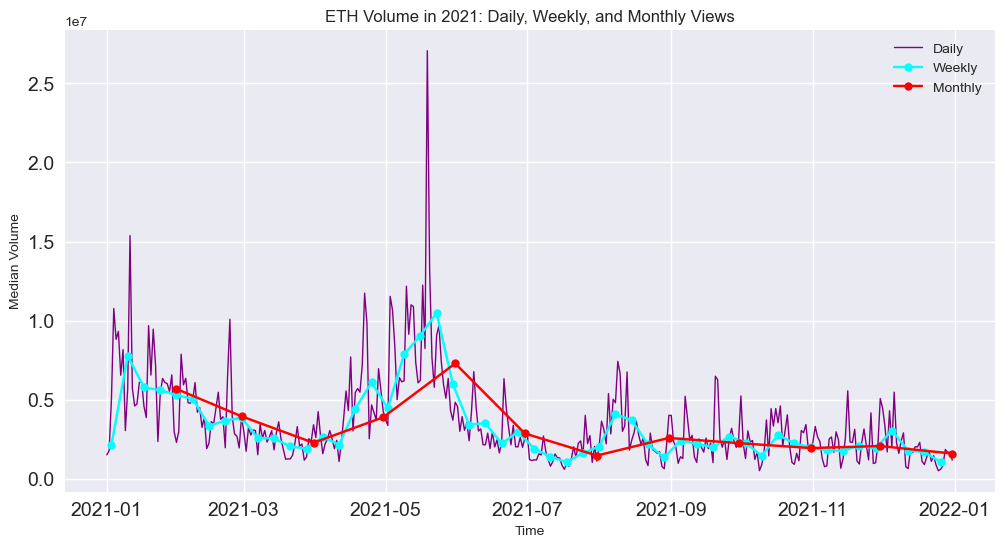

In [170]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(eth_daily.loc[start:end, 'volume'], linewidth=1, label='Daily', color='purple')
ax.plot(eth_week.loc[start:end, 'volume'], marker='o', markersize=6, linestyle='-', label='Weekly', color='cyan')
ax.plot(eth_month.loc[start:end, 'volume'], marker='o', markersize=6, linestyle='-', label='Monthly', color='red')
ax.set_title('ETH Volume in 2021: Daily, Weekly, and Monthly Views')
ax.set_xlabel('Time')
ax.set_ylabel('Median Volume')
ax.tick_params(axis='both', labelsize=14)
ax.legend()

folder_path = '../ETHtractor/visualizations/'
filename = 'ethereum_volume_2021_daily_weekly_monthly_views.png'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(os.path.join(folder_path, filename));

> Increasing volume in between April 2021 and June 2021.

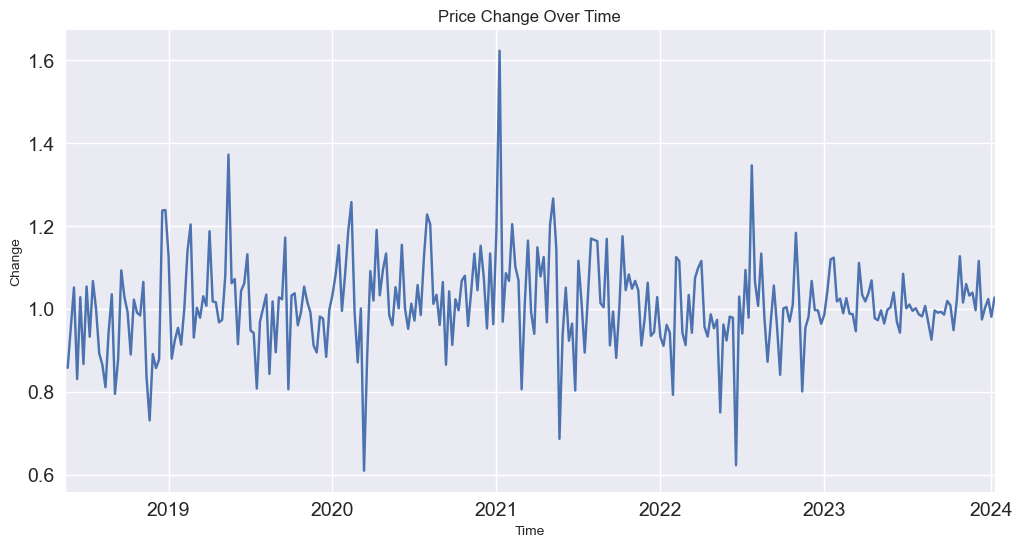

In [172]:
eth_copy = eth_week.copy()
eth_copy['change'] = eth_copy.close.div(eth_copy.close.shift())
eth_copy['change'].plot(figsize=(12,6), fontsize=14)
plt.xlabel('Time')
plt.ylabel('Change')
plt.title('Price Change Over Time')

folder_path = '../ETHtractor/visualizations/'
filename = 'ethereum_price_change_over_time.png'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(os.path.join(folder_path, filename));

> This plot shows the hourly price change ratios of the ethereum dataset. Specifically, it indicates the relative difference in closing prices between each week and the previous week over time.

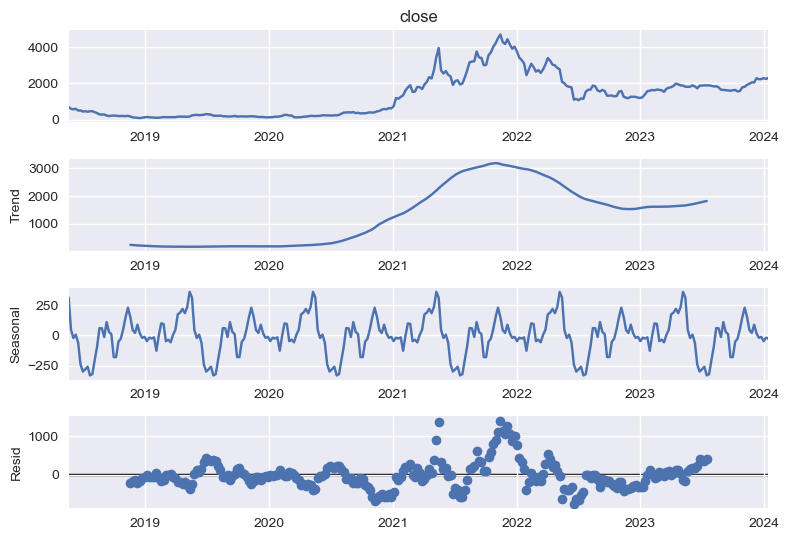

In [173]:
decomp = seasonal_decompose(eth_week['close'])
decomp.plot()

folder_path = '../ETHtractor/visualizations/'
filename = 'ethereum_seasonal_decomposition.png'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(os.path.join(folder_path, filename));

> **Observed:** This is the actual observed closing prices of Ethereum data.

> **Trend:** This plot shows the trend component extracted from the observed data. Line is moving upwards, it indicates a general increase in Ethereum prices over time.

> **Seasonal:** This plot shows the seasonal component. You would look for regular patterns within this plot to understand if there's a repeating cycle in the Ethereum prices.

> **Residual:** This plot shows the residual component. Ideally, you would want this to look like 'white noise', meaning it should have no discernible pattern. Large spikes or patterns in the residuals could indicate that the model has not fully captured all the seasonal or trend information.

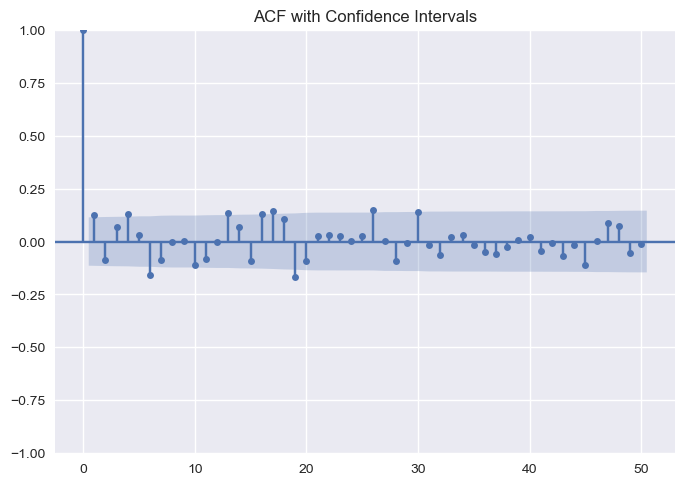

In [176]:
autocorrelation = eth.resample('W').median().fillna(method='ffill')['close']
acf_plot = plot_acf(autocorrelation.diff().dropna(), lags=50, alpha=0.05, title='ACF with Confidence Intervals')

folder_path = '../ETHtractor/visualizations/'
filename = 'ethereum_autcorrelation.png'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(os.path.join(folder_path, filename));

> Lots of noise with no lags that stand out as statistically significant.

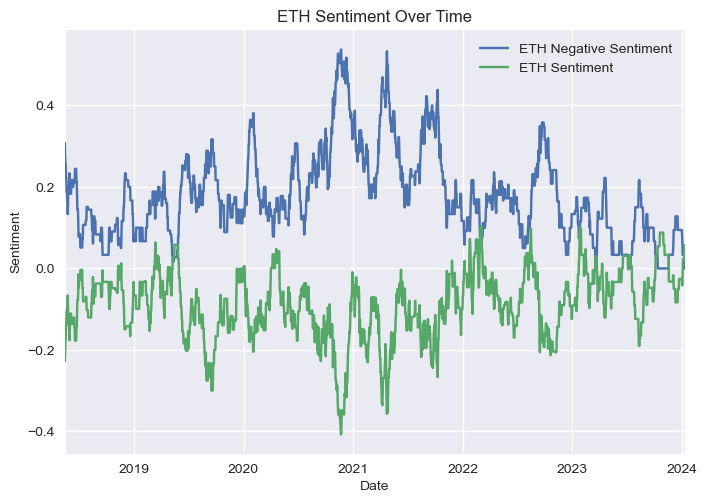

In [174]:
eth_daily['negative_sentiment'].plot.line(use_index=True, style='-', label='ETH Negative Sentiment')
eth_daily['sentiment'].plot.line(use_index=True, style='-', label='ETH Sentiment')

plt.title('ETH Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend();

folder_path = '../ETHtractor/visualizations/'
filename = 'ethereum_sentiment_and_neg_sentiment.png'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(os.path.join(folder_path, filename));

> This chart is showing that the positive sentiment for ETH in the early days was low while the negative sentiment was high but as time goes on the emotional sentiment towards ETH is shifting for the positive as the technology matures.

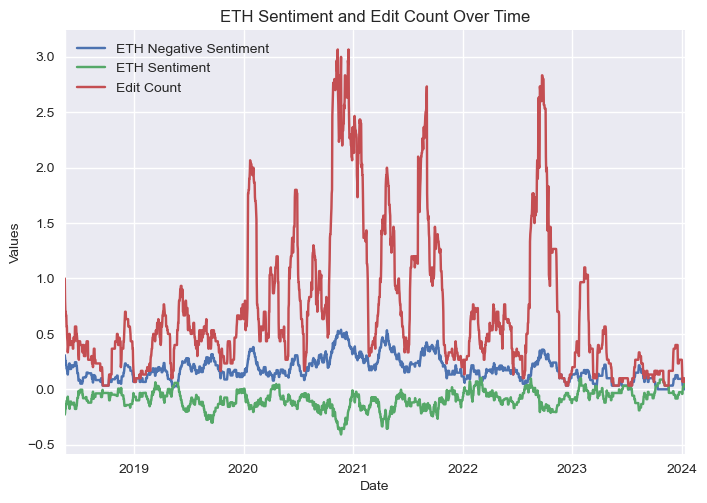

In [175]:
eth_daily['negative_sentiment'].plot.line(use_index=True, style='-', label='ETH Negative Sentiment')
eth_daily['sentiment'].plot.line(use_index=True, style='-', label='ETH Sentiment')
eth_daily['edit_count'].plot.line(use_index=True, style='-', label='Edit Count')

plt.title('ETH Sentiment and Edit Count Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend();

folder_path = '../ETHtractor/visualizations/'
filename = 'ethereum_sentiment_and_edit_count.png'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(os.path.join(folder_path, filename));

> Less edits are being made per day as the sentiment grows positive over time.

# Save CSV

In [182]:
eth.to_csv('./data/ohlcv_hour.csv')

# Train & Evaluate Models

## ARIMA (4,1,0)

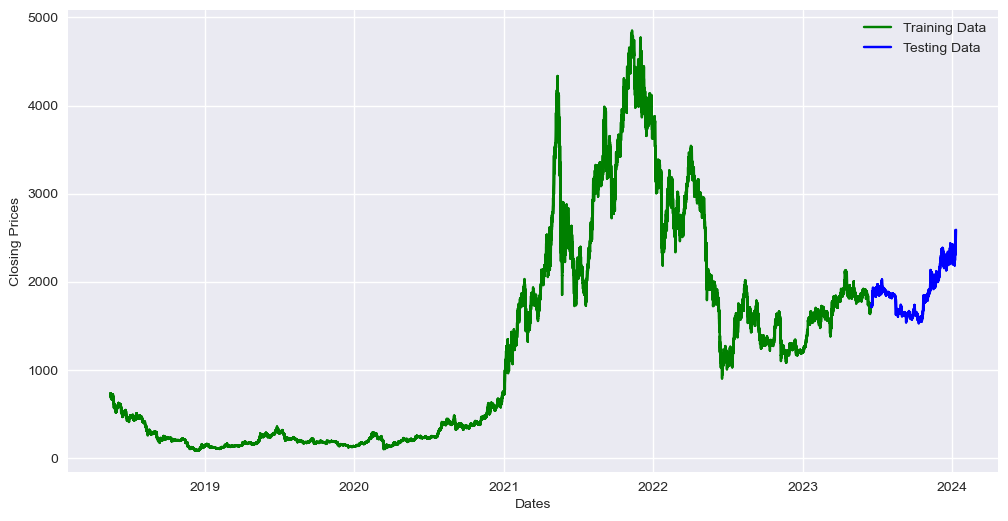

In [183]:
# 90% training / 10% testing
to_row = int(len(eth)*0.9)

training_data = list(eth[0:to_row]['close'])
testing_data = list(eth[to_row:]['close'])

plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(eth[0:to_row]['close'], 'green', label='Training Data')
plt.plot(eth[to_row:]['close'], 'blue', label='Testing Data')
plt.legend();

> Blue is what the model will be predicting.

In [185]:
model_410_predictions = []

n_test_observations = len(testing_data)

for i in range(n_test_observations):
    model = ARIMA(training_data, order=(4,1,0))
    model_410_fit = model.fit()
    output = model_410_fit.forecast()
    yhat = list(output)[0]
    model_410_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)

NameError: name 'n_test_observations' is not defined

In [ ]:
visualize_arima(eth['close'].iloc[:to_row], eth['close'].iloc[to_row:], train_preds, test_preds, suptitle='ARIMA Model (4,1,0) Predictions')

In [ ]:
print(model_410_fit.summary())

In [ ]:
plt.figure(figsize=(12,6))
plt.grid(True)

date_range = eth[to_row:].index

plt.plot(date_range, model_410_predictions, color='blue', marker='o', linestyle='-', label='ETH Predicted Price')
plt.plot(date_range, testing_data, color='red', label='ETH Actual Price')
plt.title('ARIMA (4,1,0) ETH Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend();

In [ ]:
mape = round(np.mean(np.abs(np.array(model_410_predictions) - np.array(testing_data)) / np.abs(testing_data)), 3)
print(f'Mean Absolute Percentage Error: {str(mape)}')

## ARIMA (1,1,0)

In [ ]:
to_row = int(len(eth)*0.9)

training_data = list(eth[0:to_row]['close'])
testing_data = list(eth[to_row:]['close'])

In [ ]:
train_preds = []
for i in range(to_row, len(eth)):
    model = ARIMA(training_data, order=(1,1,0))
    model_110_fit = model.fit()
    output = model_110_fit.forecast()[0]
    train_preds.append(output)

test_preds = []
for i in range(n_test_observations):
    model = ARIMA(training_data, order=(1,1,0))
    model_110_fit = model.fit()
    output = model_110_fit.forecast()[0]
    test_preds.append(output)

train_preds = pd.Series(train_preds, index=eth[to_row:]['close'].index)
test_preds = pd.Series(test_preds, index=eth[to_row:]['close'].index)

In [ ]:
visualize_arima(eth['close'].iloc[:to_row], eth['close'].iloc[to_row:], train_preds, test_preds, suptitle='ARIMA Model (1,1,0) Predictions')

In [ ]:
print(model_110_fit.summary())

In [ ]:
plt.figure(figsize=(12,6))
plt.grid(True)

date_range = eth[to_row:].index

plt.plot(date_range, model_110_predictions, color='blue', marker='o', linestyle='-', label='ETH Predicted Price')
plt.plot(date_range, testing_data, color='red', label='ETH Actual Price')
plt.title('ARIMA (1,1,0) ETH Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend();

In [ ]:
mape = round(np.mean(np.abs(np.array(model_110_predictions) - np.array(testing_data)) / np.abs(testing_data)), 3)
print(f'Mean Absolute Percentage Error: {str(mape)}')

## Split Data

In [ ]:
eth_main = eth.loc['2018-05-15':'2023-09-29']
eth_holdout = eth.loc['2023-09-30':]

window = int(eth_main.shape[0]*0.9)

training_dataset = eth_main[:window]
testing_dataset = eth_main[window:]

scaler = MinMaxScaler(feature_range=(0,1))
df_train = scaler.fit_transform(training_dataset)
df_test = scaler.transform(testing_dataset)

X_train, y_train = create_data(df_train, 50, -1)
X_test, y_test = create_data(df_test, 50, -1)

## RandomForest

In [ ]:
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

rf_model = RandomForestRegressor()

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(np.squeeze(X_train), np.squeeze(y_train))

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

best_rf_model.fit(np.squeeze(X_train), np.squeeze(y_train))

assess_and_compare_forecast_model(best_rf_model, model_name='RandomForest', test_data=np.squeeze(X_test), target_data=np.squeeze(y_test))

## XGBoost

In [ ]:
param_grid = {'max_depth': [3, 5, 7, 10],
              'learning_rate': [0.01, 0.1, 0.5, 1],
              'n_estimators': [50, 100, 200, 500]}

xgb_model = XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(np.squeeze(X_train), np.squeeze(y_train))

best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

best_xgb_model.fit(np.squeeze(X_train), np.squeeze(y_train))

assess_and_compare_forecast_model(best_xgb_model, model_name='XGBoost', test_data=np.squeeze(X_test), target_data=np.squeeze(y_test))

## Convolutional Neural Network (CNN)

In [ ]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=MSE,
    metrics=['mae']
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = cnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

assess_and_compare_forecast_model(cnn_model, model_name='CNN')

In [ ]:
cnn_model.summary()

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show();

## Long Short-Term Memory (LSTM)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(units=32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1)
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=MSE,
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = lstm_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

assess_and_compare_forecast_model(lstm_model, model_name='LSTM')

In [ ]:
lstm_model.summary()

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.history['mae'])
plt.plot(history2.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show();

# Results

In [ ]:
model_metrics = {'Model': ['RandomForest', 'XGBoost', 'CNN', 'LSTM'],
                 'R-squared': [], 
                 'MAE': []}

df_result = pd.DataFrame(model_metrics)
df_result.set_index('Model', inplace=True)
df_result

# Deploy Holdout Data Into Best Model

In [ ]:
scaled_holdout = scaler.fit_transform(eth_holdout)

X_test2, y_test2 = extract_sequence_and_label_data(scaled_holdout, 50, -1)

assess_and_compare_forecast_model(.., '..', X_test2, y_test2)